# Modelos ARIMA



In [1]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Conexión de google drive con el repo
from google.colab import drive
drive.mount('/content/drive')
ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
os.chdir(ruta)
##==========================
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directorio de trabajo: /content/drive/MyDrive/MonografiaUdeA


In [3]:
modelo_implementar = ['SARIMAX']

def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()#.iloc[:,[0]].reset_index()
df = df[['precio_bolsa', 'precio_oferta']].reset_index()

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)
df.head()

,precio_bolsa,precio_oferta
fecha,,
2010-01-01,120.501228,267.437633
2010-01-02,118.495340,277.153592
2010-01-03,121.160145,313.552755
2010-01-04,123.962937,303.519878
2010-01-05,120.666437,339.600449


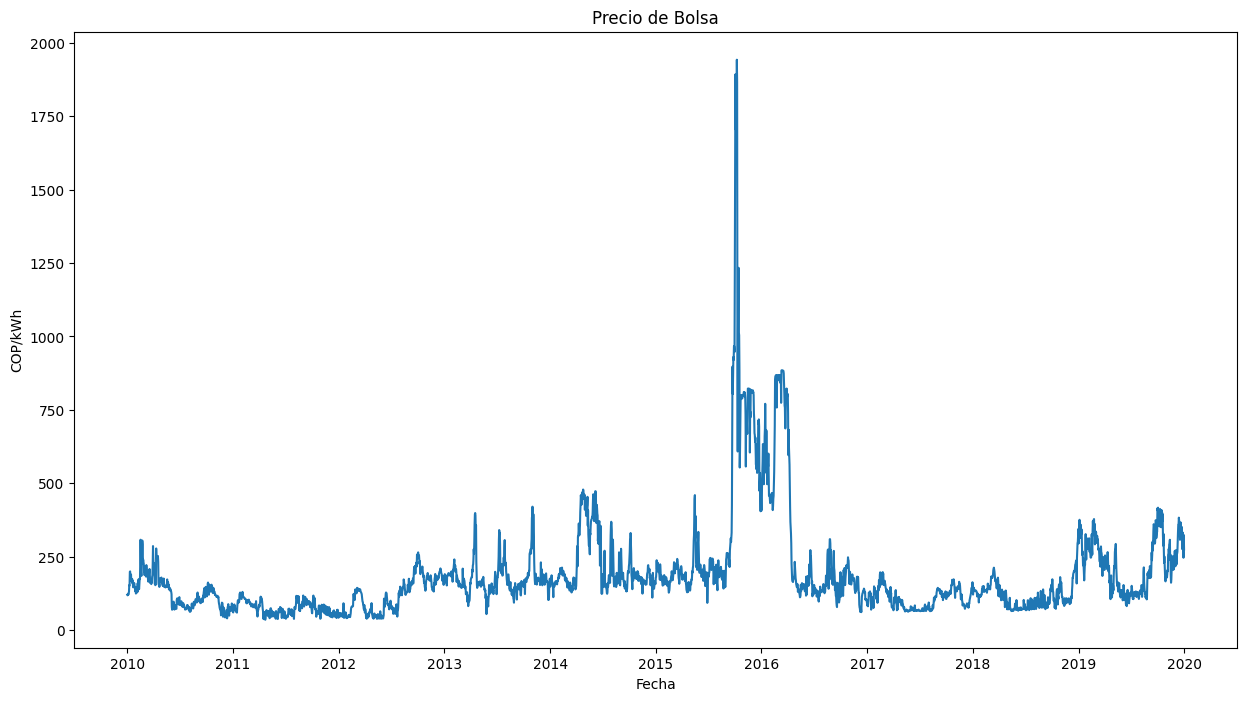

In [5]:
# Plot the time series
plt.figure(figsize = (15,8))
plt.plot(df['precio_bolsa'])
plt.title('Precio de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('COP/kWh')
plt.show()

## Validación de estacionariedad

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['precio_bolsa'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.436130
p-value: 0.000256


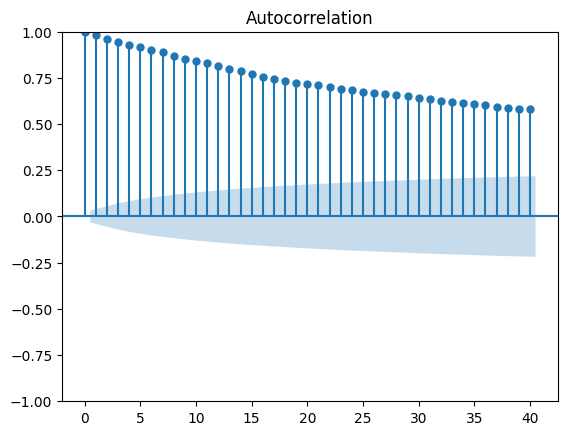

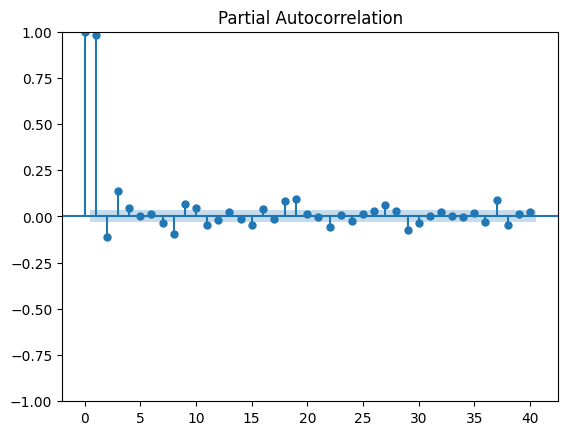

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['precio_bolsa'], lags=40)
plot_pacf(df['precio_bolsa'], lags=40)
plt.show()

Un valor p inferior a 0,05 indica estacionariedad y nuestros datos cumplen con este criterio, por lo que no es necesario realizar diferenciación.

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = ARIMA(df['precio_bolsa'], order=(1, 0, 1))
# model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [9]:
# forecast = model_fit.get_forecast(steps=30)

In [11]:
from sklearn.metrics import mean_squared_error

def sarimax_model (df, p, d , q , P , D , Q , s , train_porc = 0.8):
    train_size = int(len(df) * train_porc)
    train, test = df[0:train_size], df[train_size:len(df)]

    model_train = SARIMAX(train['precio_bolsa'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_train_fit = model_train.fit()

    test_forecast = model_train_fit.get_forecast(steps=len(test))
    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

    mse = mean_squared_error(test['precio_bolsa'], test_forecast_series)
    mape = mean_absolute_percentage_error(test['precio_bolsa'], test_forecast_series)
    rmse = mse**0.5

    return (mape, mse, rmse, model_train_fit)

In [14]:
from itertools import product

p_values = range(1, 6)
d_values = range(0, 3)
q_values = range(1, 6)
P_values = range(1, 6)
D_values = range(0, 3)
Q_values = range(1, 6)
s_values = [12]
combinacion_parametros = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

In [15]:
import warnings
warnings.filterwarnings("ignore")
def get_best_model(df, combinacion_parametros):
    best_score = float("inf")
    best_params = []
    for element in combinacion_parametros:
        p, d, q, P, D, Q, s = element
        mape, mse, rmse, model = sarimax_model(df,p = p, d = d, q = q, P = P, D = D, Q = Q, s=s)
        print(element, mse)
        if mse < best_score:
            best_score, best_params = mse, element

    return mse, best_params

mape, best_params = get_best_model(df, combinacion_parametros)

(1, 0, 1, 1, 0, 1, 12)
(1, 0, 1, 1, 0, 2, 12)
(1, 0, 1, 1, 0, 3, 12)
(1, 0, 1, 1, 0, 4, 12)
(1, 0, 1, 1, 0, 5, 12)
(1, 0, 1, 1, 1, 1, 12)
(1, 0, 1, 1, 1, 2, 12)
(1, 0, 1, 1, 1, 3, 12)
(1, 0, 1, 1, 1, 4, 12)
(1, 0, 1, 1, 1, 5, 12)
(1, 0, 1, 1, 2, 1, 12)
(1, 0, 1, 1, 2, 2, 12)
(1, 0, 1, 1, 2, 3, 12)
(1, 0, 1, 1, 2, 4, 12)
(1, 0, 1, 1, 2, 5, 12)
(1, 0, 1, 2, 0, 1, 12)
(1, 0, 1, 2, 0, 2, 12)
(1, 0, 1, 2, 0, 3, 12)
(1, 0, 1, 2, 0, 4, 12)
(1, 0, 1, 2, 0, 5, 12)
(1, 0, 1, 2, 1, 1, 12)
(1, 0, 1, 2, 1, 2, 12)
(1, 0, 1, 2, 1, 3, 12)
(1, 0, 1, 2, 1, 4, 12)
(1, 0, 1, 2, 1, 5, 12)
(1, 0, 1, 2, 2, 1, 12)
(1, 0, 1, 2, 2, 2, 12)
(1, 0, 1, 2, 2, 3, 12)
(1, 0, 1, 2, 2, 4, 12)
(1, 0, 1, 2, 2, 5, 12)
(1, 0, 1, 3, 0, 1, 12)
(1, 0, 1, 3, 0, 2, 12)
(1, 0, 1, 3, 0, 3, 12)
(1, 0, 1, 3, 0, 4, 12)
(1, 0, 1, 3, 0, 5, 12)
(1, 0, 1, 3, 1, 1, 12)
(1, 0, 1, 3, 1, 2, 12)
(1, 0, 1, 3, 1, 3, 12)
(1, 0, 1, 3, 1, 4, 12)
(1, 0, 1, 3, 1, 5, 12)
(1, 0, 1, 3, 2, 1, 12)
(1, 0, 1, 3, 2, 2, 12)
(1, 0, 1, 3, 2, 3, 12)
(1, 0, 1, 3

LinAlgError: LU decomposition error.

In [ ]:
!pip install pmdarima -q
import pmdarima as pm

In [ ]:
# SARIMAX_model = pm.auto_arima(df[['precio_bolsa']],
#                               exogenous=df[['precio_oferta']],
#                               start_p=1, start_q=1,
#                               test='adf',
#                               max_p=6, max_q=6, m=12,
#                               start_P=0, seasonal=True,
#                               d=None, D=1,
#                               trace=False,
#                               error_action='ignore',
#                               suppress_warnings=True,
#                               stepwise=True,
#                               stationary = True)

In [ ]:
import pickle
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'wb') as f:
    pickle.dump(SARIMAX_model,f)

In [ ]:
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'rb') as f:
    mp = pickle.load(f)

In [ ]:
mp.summary()

In [ ]:
def sarimax_forecast(model, periods=30):
    n_periods = periods
    forecast_df = pd.DataFrame({"fecha": pd.date_range(df.index[-1], periods=n_periods, freq='D').day},
                               index=pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='D'))

    fitted, confint = model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['fecha']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["precio_bolsa"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Pronóstico del Precio de la Energpia en Bolsa")
    plt.show()

    return fitted_series

fitted_series = sarimax_forecast(mp, periods=31)

In [ ]:
# !pip install pydataxm
import pydataxm
from pydataxm.pydataxm import ReadDB
consult = ReadDB()

In [ ]:
precio_bolsa = consult.request_data("PrecBolsNaci", "Sistema", dt.date(2020, 1, 1), dt.date(2020, 1, 31) )
hours = [f"Values_Hour{str(i).zfill(2)}" for i in range(1,25)]
precio_bolsa['precio_bolsa'] = precio_bolsa[hours].mean(axis=1)
precio_bolsa = precio_bolsa.groupby('Date')['precio_bolsa'].mean().reset_index()
precio_bolsa = precio_bolsa[ ['Date'] + ['precio_bolsa']]
precio_bolsa = precio_bolsa.rename(columns = {'Date': 'fecha'}).sort_values(by = 'fecha', ascending = True).reset_index(drop = True)
precio_bolsa['fecha'] = pd.to_datetime(precio_bolsa['fecha'])
precio_bolsa = precio_bolsa.set_index('fecha')
precio_bolsa.to_csv(os.path.join(abspath,"datasets", "procesado","precio_bolsa_ene_2020.csv"), index=True)

In [ ]:
precio_bolsa_pronosticado = pd.DataFrame(fitted_series, columns = ['precio_bolsa_pronosticado'])
df_final = pd.merge(precio_bolsa,precio_bolsa_pronosticado, how = 'left', left_index = True, right_index=True)
df_final.tail()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

element_to_predict = 31
mse = mean_squared_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
mae = mean_absolute_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
rmse = mean_squared_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):], squared=False)
mape = mean_absolute_percentage_error(df_final["precio_bolsa"][-int(element_to_predict):], df_final["precio_bolsa_pronosticado"][-int(element_to_predict):])
print("mse", mse.round(3))
print("mae", mae.round(3))
print("rmse", rmse.round(3))
print("mape", mape.round(3))